In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from integration.integrate import *

from tqdm import tqdm

In [12]:
@jit(nopython=True)
def f(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x)

@jit(nopython=True)
def g(x,t):
    return np.zeros((2,2))

@jit(nopython=True)
def f_cubic(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x**3)

In [13]:
ti,tf,dt = 0,25,0.005
times = np.arange(ti,tf,dt)
x0=np.array([2.,0.])
xx1 = integrate(f,g,x0,times,dt,mode="euler")
xx1_cubic = integrate(f_cubic,g,x0,times,dt,mode="euler")


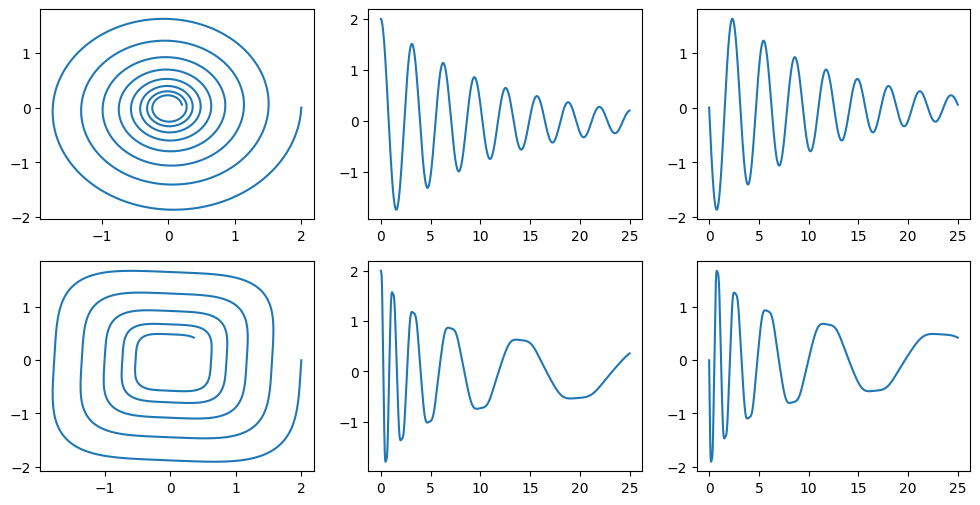

In [14]:
plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax = plt.subplot(233)
ax.plot(times, xx1[1,:])

ax = plt.subplot(234)
ax.plot(xx1_cubic[0,:], xx1_cubic[1,:])
ax = plt.subplot(235)
ax.plot(times, xx1_cubic[0,:])
ax = plt.subplot(236)
ax.plot(times, xx1_cubic[1,:])

In [15]:
name = "data/lineal_oscillator/"
os.makedirs(name,exist_ok=True)
np.save(name+"{}_{}_{}".format(ti,tf,dt), xx1)

name = "data/cubic_oscillator/"
os.makedirs(name,exist_ok=True)
np.save(name+"{}_{}_{}".format(ti,tf,dt), xx1_cubic)

In [7]:
ti,tf,dt = 0,25,0.005
times = np.arange(ti,tf,dt)
x0=np.array([2.,0.])
xx1 = integrate(f,g,x0,times,dt,mode="RK4")

In [16]:
from sklearn import linear_model

X = xx1.T
X_dot = np.array([f(xx,t) for xx,t in zip(xx1.T, times)])


#Th = {'1':X,'3': X**3}
#Th_value = np.concatenate(list(Th.values()), axis=-1)
f0 = lambda k: k
f1 = lambda k: k**3
Th_value = np.concatenate([f0(X), f1(X)], axis=-1)

lin_mod = linear_model.Lasso(alpha=0.001,tol=1e-14)
lasso_model = lin_mod.fit(Th_value, X_dot)


In [17]:
#help(lasso_model.score) Computes R**2
print("R^: ", lasso_model.score(Th_value, X_dot) ) #

# MSE: 
print("MSE: " , np.mean((Th_value.dot(lasso_model.coef_.T) - X_dot)**2))

R^:  0.9999967605947943
MSE:  5.703397349000268e-06


100%|███████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 100124.28it/s]


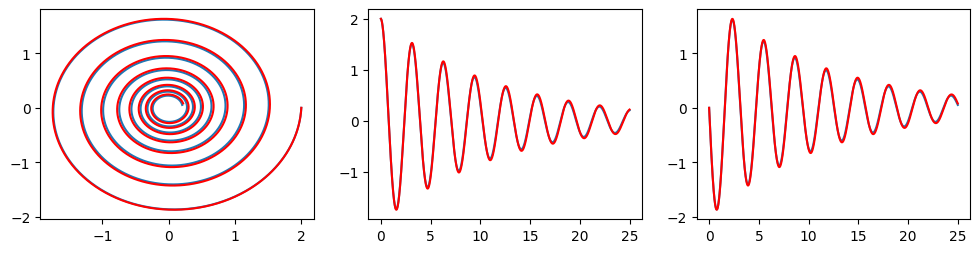

In [18]:
coeffs = lasso_model.coef_.T
constrain = np.abs(coeffs)<1e-2
coeffs[constrain] = 0.


x_hat = np.array([2,0.])
x_hats = [x_hat]
for x in tqdm(X[:-1]):
    x_hat = x_hat + dt*np.concatenate([f0(x_hat), f1(x_hat)]).dot(coeffs)
    x_hats.append(x_hat)
x_hats = np.array(x_hats)

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(x_hats[:,0], x_hats[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax.plot(times, x_hats[:,0], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1[1,:])
ax.plot(times, x_hats[:,1], color="red")


In [19]:
from sklearn import linear_model

xx1_cubic = integrate(f_cubic,g,x0,times,dt,mode="RK4")

X = xx1_cubic.T
X_dot = np.array([f_cubic(xx,t) for xx,t in zip(xx1_cubic.T, times)])


#Th = {'1':X,'3': X**3}
#Th_value = np.concatenate(list(Th.values()), axis=-1)
f0 = lambda k: k
f1 = lambda k: k**3
Th_value = np.concatenate([f0(X), f1(X)], axis=-1)

lin_mod = linear_model.Lasso(alpha=0.0001,tol=1e-14)
lasso_model = lin_mod.fit(Th_value, X_dot)

coeffs = lasso_model.coef_.T

print(coeffs)

[[-0.         -0.        ]
 [ 0.         -0.        ]
 [-0.09988283 -1.99987059]
 [ 1.99987865 -0.0998664 ]]


In [388]:
Th_value = np.concatenate([f0(X), f1(X)], axis=-1)
Th_value.shape

(5000, 4)

In [385]:
lasso_model.coef_.T.shape

(4, 2)

array([[ 2.00000000e+00,  0.00000000e+00,  8.00000000e+00,
         0.00000000e+00],
       [ 1.99601083e+00, -7.97606955e-02,  7.95222539e+00,
        -5.07419085e-04],
       [ 1.99202782e+00, -1.59044333e-01,  7.90471467e+00,
        -4.02304231e-03],
       ...,
       [-4.43029463e-01, -2.82316534e-01, -8.69556545e-02,
        -2.25013691e-02],
       [-4.43209921e-01, -2.81435247e-01, -8.70619560e-02,
        -2.22913035e-02],
       [-4.43388231e-01, -2.80553008e-01, -8.71670772e-02,
        -2.20823245e-02]])

In [375]:
#help(lasso_model.score) Computes R**2
print("R^: ", lasso_model.score(Th_value, X_dot) ) #

# MSE: 
print("MSE: " , np.mean((Th_value.dot(lasso_model.coef_.T) - X_dot)**2))

R^:  0.9999999921837074
MSE:  2.5114295613813887e-08


In [408]:
coeffs

array([[-0.        , -0.        ],
       [ 0.        , -0.        ],
       [-0.09988283, -1.99987059],
       [ 1.99987865, -0.0998664 ]])

In [413]:
aa = np.array([[0,0],[0,0],[-.1, 2],[-2,-.1]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 86919.48it/s]


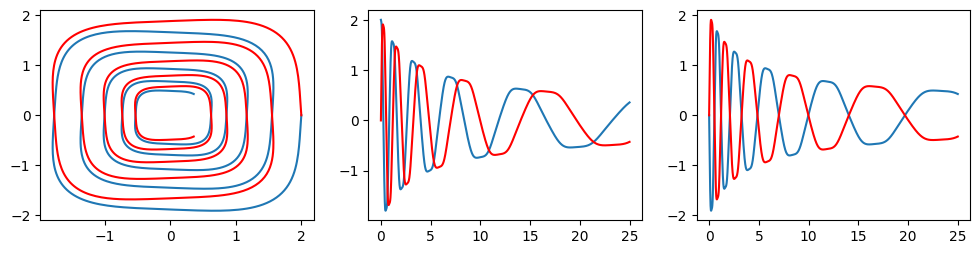

In [417]:
x_hat = np.array([2,0.])
x_hats = [x_hat]
for x in tqdm(X[:-1]):
    x_hat = x_hat + dt*np.concatenate([f0(x_hat), f1(x_hat)]).dot(aa)
    x_hats.append(x_hat)
x_hats = np.array(x_hats)

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1_cubic[0,:], xx1_cubic[1,:])
ax.plot(x_hats[:,0], x_hats[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1_cubic[0,:])
ax.plot(times, x_hats[:,1], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1_cubic[1,:])
ax.plot(times, x_hats[:,1], color="red")


array([[ 2.        ,  1.99601083,  1.99202782, ..., -0.44302946,
        -0.44320992, -0.44338823],
       [ 0.        , -0.0797607 , -0.15904433, ..., -0.28231653,
        -0.28143525, -0.28055301]])